In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from simple_wta import WTAProblem, random_wta_factory
import kmeans_clustering
import spectral_clustering
import ahuja
from matplotlib import pyplot as plt

In [2]:
# generate random problems
rng = np.random.seed(42)
n_w = 50
n_t = 50
n_c = 7
probs = [random_wta_factory(n_w,n_t) for i in range(5000)]

In [3]:
# solve the problems with ahuja method
X = [ahuja.optimize(p,ftol_abs=1e-3) for p in probs]

c:\Python39\lib\site-packages\numpy\lib\function_base.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


Ended at maximum iterations


In [4]:
# perform the clustering
n_c = 7
# cluster_data = [spectral_clustering.reduce_problem(p,n_c,rng=rng) for p in probs]
cluster_data = [kmeans_clustering.reduce_problem(p,n_c,rng=rng) for p in probs]


In [5]:
# create heatmap of weapon-target assignment matrix without cluster reorganization
data1 = np.zeros((n_w,n_t))
for i in range(len(probs)):
    for j in range(n_w):
        data1[j,X[i][j]]+=1

In [6]:
# create heatmap that is reorganized by cluster data
import matplotlib.cm
data2 = np.zeros((n_w,n_t))
for i in range(len(probs)):
    weapon_off = 0
    target_off = 0
    row = np.zeros(shape=(n_w,),dtype=int)
    col = np.zeros(shape=(n_t,),dtype=int)
    for j in range(n_c):
        W = cluster_data[i][1][j]
        T = cluster_data[i][2][j]
        # reassign weapon and target indices
        for k in range(len(W)):
            row[W[k]] = weapon_off+k
        weapon_off += len(W)
        for k in range(len(T)):
            col[T[k]] = target_off+k
        target_off += len(T)
    for j in range(n_w):
        data2[row[j],col[X[i][j]]] += 1
data1 = data1/len(probs)
data2 = data2/len(probs)

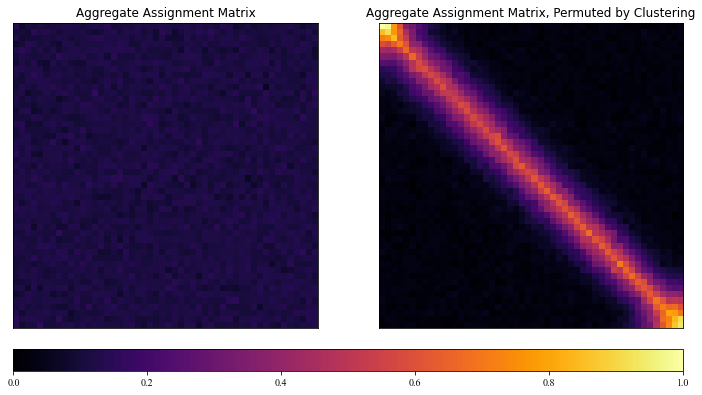

In [7]:
import matplotlib
mins = [np.min(data1), np.min(data2)]
maxs = [np.max(data1), np.max(data2)]
vmin = np.min(mins)
vmax = np.max(maxs)
fig, axes = plt.subplots(1,2,sharey=True,figsize=(12,6))
matplotlib.rcParams["font.family"] = ["serif"]
matplotlib.rcParams["font.serif"] = ["Times New Roman"]
axes[0].imshow(data1,vmin=vmin,vmax=vmax,cmap="inferno")
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Aggregate Task Assignment")
axes[1].imshow(data2,vmin=vmin,vmax=vmax,cmap="inferno")
axes[1].set_xticks([])
axes[1].set_title("Aggregate Assignment, Permuted by Partitions")
cax = plt.axes([.125,.05,.775,.05])
fig.colorbar(matplotlib.cm.ScalarMappable(cmap="inferno"),orientation="horizontal",cax=cax)
plt.savefig("figures/heatmap_compare_cbar.png")

In [8]:
# idea
# look at MANY different clusterings, then calculate a ratio of 

# R = C / (N*M)

# where C is number of assignments that respect the problem clustering
# N is the number of weapons 
# M is the number of randomly generated WTA problems

# Larger R indicates the clustering method is a better approximation of the problems

n_c = [2,3,4,5,6,7]
C = np.zeros(len(n_c))
R = np.zeros(len(n_c))
data = np.zeros((len(n_c),n_w,n_t))
for i in range(len(n_c)):
    cluster_data = [kmeans_clustering.reduce_problem(p,n_c[i],rng=rng) for p in probs]
    for j in range(len(probs)):
        weapon_off = 0
        target_off = 0
        row = np.zeros(shape=(n_w,),dtype=int)
        col = np.zeros(shape=(n_t,),dtype=int)
        for k in range(n_c[i]):
            W = cluster_data[j][1][k]
            T = cluster_data[j][2][k]
            # reassign weapon and target indices
            for l in range(len(W)):
                row[W[l]] = weapon_off+l
            weapon_off += len(W)
            for l in range(len(T)):
                col[T[l]] = target_off+l
            target_off += len(T)
        for k in range(n_w):
            data[i,row[k],col[X[j][k]]] += 1
    row = int(i/3)
    col = i % 3
    idx = (int(i/3),i%3)
data = data / len(probs)

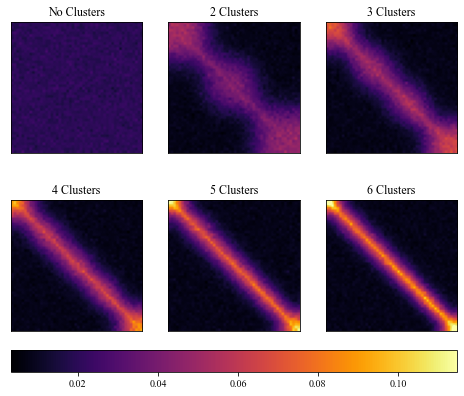

In [29]:

fig,axs = plt.subplots(nrows=2,ncols=3,figsize=(8,6))
vmin = np.min([np.min(data1),np.min(data[:-1,:,:])])
vmax = np.max([np.max(data1),np.max(data[:-1,:,:])])
axs[0,0].imshow(data1,cmap="inferno",vmin=vmin,vmax=vmax)
axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].set_title("No Clusters") 
for i in range(1,len(n_c)):
    row = int(i/3)
    col = i % 3
    idx = (int(i/3),i%3)
    axs[idx].imshow(data[i,:,:],cmap="inferno",vmin=vmin,vmax=vmax)
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])
    axs[idx].set_title("%d Clusters"%(n_c[i-1])) 
cax = plt.axes([.125,.05,.775,.05])
norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm,cmap="inferno"),orientation="horizontal",cax=cax)
plt.savefig("figures/heatmap_compare_grid.png",dpi=1000)

In [22]:
np.shape(data[:-1,:,:])

(5, 50, 50)